### Mapping of A1 and A2 adult human colon 10X Genomics Visium samples and `cell2location`

- **Developed by:** Anna Maguza
- **Affilation:** Faculty of Medicine, Würzburg University
- **Date of creation:** 1st August 2024
- **Last modified date:** 6th August 2024

##### Import packages

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import cell2location

from matplotlib import rcParams

import torch

import os

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


##### Setup working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                         10.2.0
absl                        NA
aiohttp                     3.9.1
aiosignal                   1.3.1
annotated_types             0.6.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
async_timeout               4.0.3
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
backcall                    0.2.0
backoff                     2.2.1
brotli                      1.1.0
bs4                         4.12.3
cell2location               0.1.3
certifi                     2023.11.17
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.7
click                       8.1.7
comm                        0.2.1
contextlib2                 NA
croniter                    NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2

In [3]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

In [4]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

# Train the reference

### Read in data

In [12]:
adata_ref = sc.read_h5ad('/../../../gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results/reference_datasets/Adult_colon_reference.h5ad')

+ Permissive genes selection

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


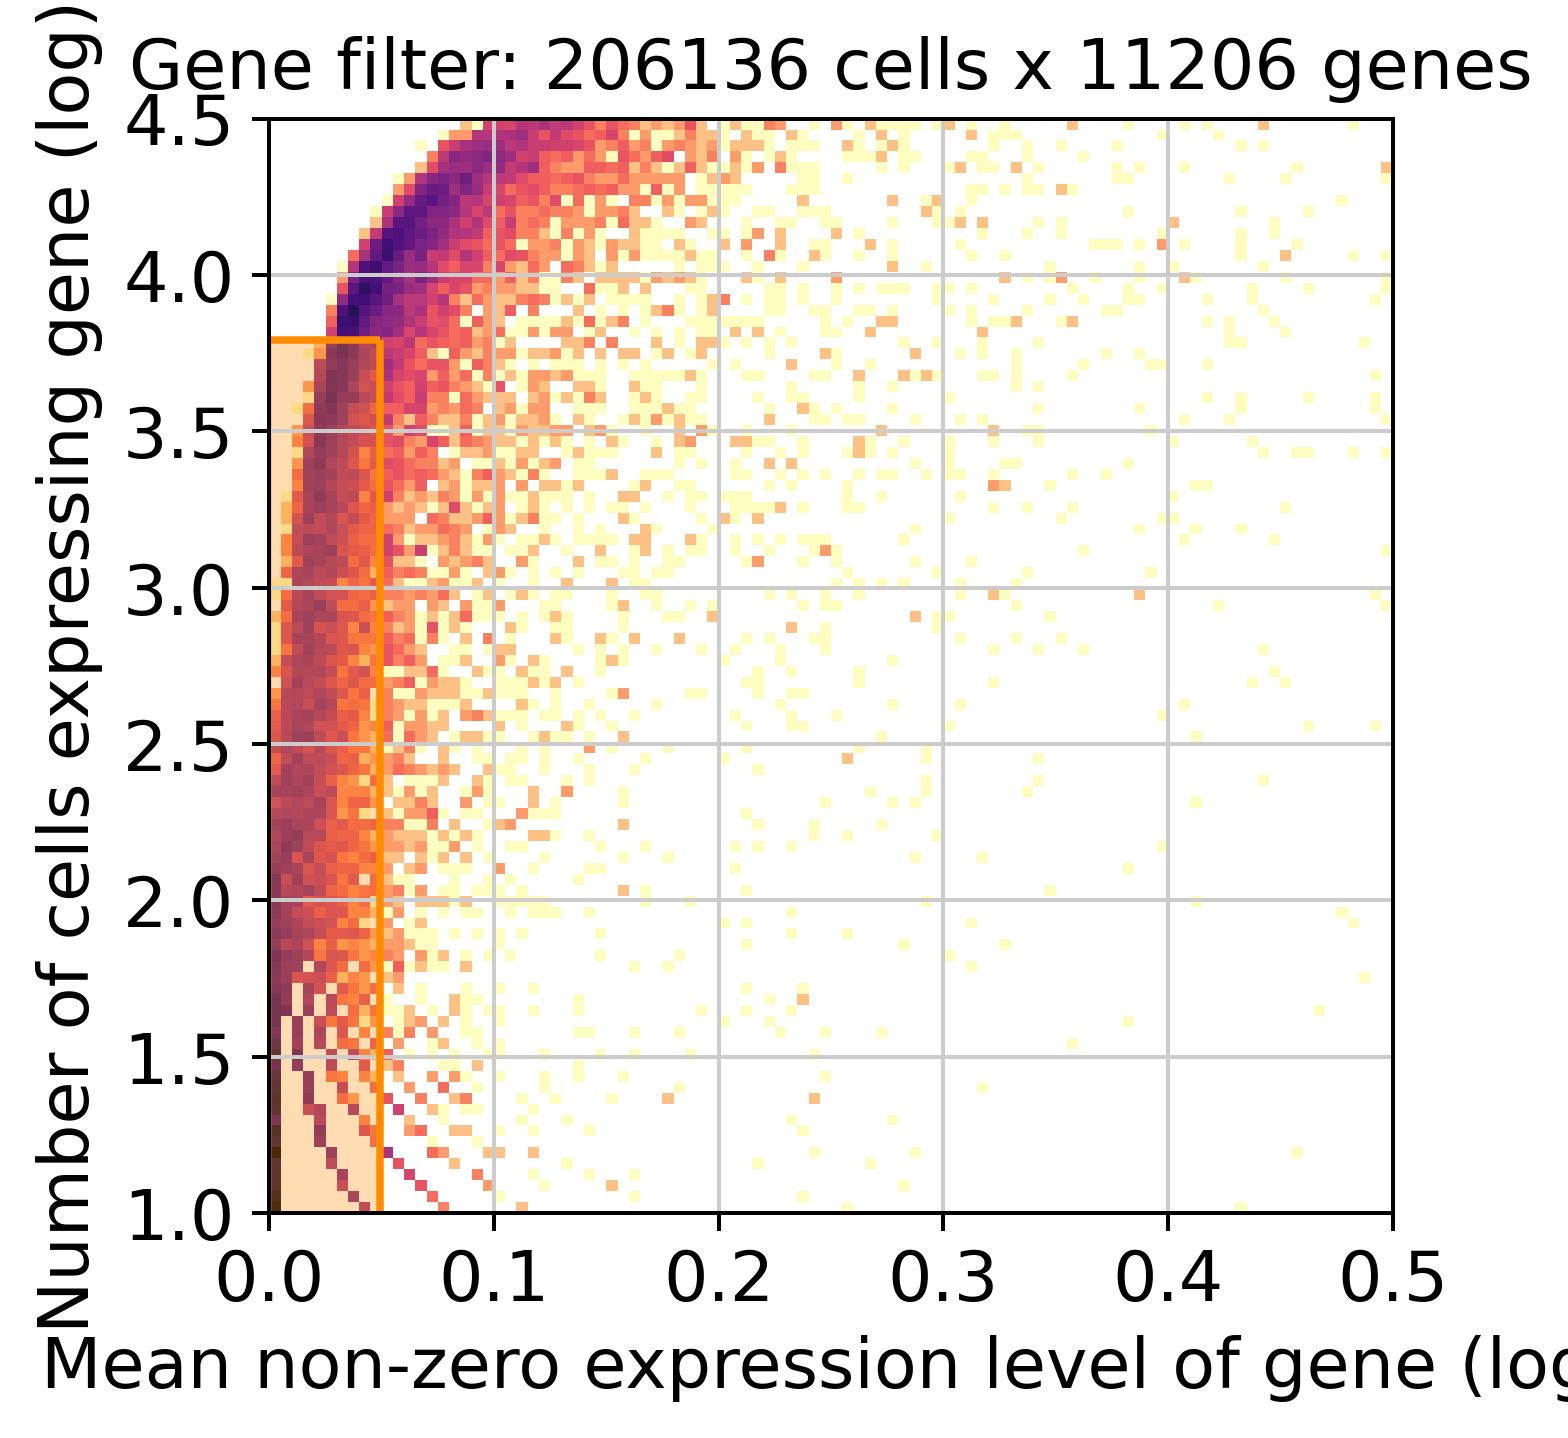

In [8]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

### Estimation of reference cell type signatures (NB regression)

In [10]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='Sample_ID',
                        # cell type, covariate used for constructing signatures
                        labels_key='seed_labels',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['Study_name', 'Library_Preparation_Protocol']
                       )

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/data/fields/_dataframe_field.py:189: UserWarning: Category 55 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/data/fields/_dataframe_field.py:189: UserWarning: Category 8 in adata.obs['_scvi_labels'] has 

In [11]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample_ID',
│   'labels_key': 'seed_labels',
│   'categorical_covariate_keys': ['Study_name', 'Library_Preparation_Protocol'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │  180   │
│         n_cells          │ 206136 │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   48   │
│          n_vars          │ 11206  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                         batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample_ID'] │   A26-CAE-0-SC-1    │          0          │
│                        │   A26-SCL-0-SC-1    │          1          │
│                        │   A26-TCL-0-SC-1    │          2          │
│                        │ A30-SCL-6-SC-45N-1  │          3          │
│                        │ A30-SCL-6-SC-45N-2  │          4          │
│                        │ A30-SCL-6-SC-45P-1  │          5          │
│                        │ A30-SCL-6-SC-45P-2  │          6          │
│                        │ A32-CAE-0-SC-45N-1  │          7          │
│                        │ A32-CAE-0-SC-45P-1  │          8          │
│                        │ A32-SCL-0-SC-45N-1  │          9          │
│                        │ A32-SCL-0-SC-45P-1  │         10          │
│                        │ A32-TCL-0-SC-45N-1  │         11          │
│                        │ A32-TCL-0-SC-45P-1  │         12          │
│                        │ A33-ACL-0-SC-45P-1  │         13          │
│                        │ A33-CAE-0-SC-45N-1  │         14          │
│                        │ A33-CAE-0-SC-45P-1  │         15          │
│                        │ A33-REC-0-SC-45N-1  │         16          │
│                        │ A33-REC-0-SC-45P-1  │         17          │
│                        │ A33-SCL-0-SC-45N-1  │         18          │
│                        │ A33-TCL-0-SC-45N-1  │         19          │
│                        │ A33-TCL-0-SC-45P-1  │         20          │
│                        │ A34-ACL-1-SC-45N-1  │         21          │
│                        │ A34-ACL-1-SC-45P-1  │         22          │
│                        │ A34-CAE-1-SC-45N-1  │         23          │
│                        │ A34-CAE-1-SC-45P-1  │         24          │
│                        │ A34-DCL-1-SC-45N-1  │         25          │
│                        │ A34-DCL-1-SC-45P-1  │         26          │
│                        │ A34-REC-1-SC-45N-1  │         27          │
│                        │ A34-REC-1-SC-45P-1  │         28          │
│                        │ A34-SCL-1-SC-45N-1  │         29          │
│                        │ A34-SCL-1-SC-45P-1  │         30          │
│                        │ A34-TCL-1-SC-45N-1  │         31          │
│                        │ A34-TCL-1-SC-45P-1  │         32          │
│                        │ A38-ACL-1-SC-45N-1  │         33          │
│                        │ A38-ACL-1-SC-45P-1  │         34          │
│                        │   A38-CAE-1-SC-1    │         35          │
│                        │   A38-DCL-1-SC-1    │         36          │
│                        │   A38-REC-1-SC-1    │         37          │
│                        │   A38-SCL-1-SC-1    │         38          │
│                        │ A38-TCL-1-SC-45N-1  │         39          │
│                        │ A38-TCL-1-SC-45P-1  │         40          │
│                        │    A39-ACL--SC-1    │         41          │
│                        │    A39-CAE--SC-1    │         42          │
│                        │    A39-DCL--SC-1    │         43          │
│                        │    A39-SCL--SC-1    │         44          │
│                        │    A39-TCL--SC-1    │         45          │
│                        │      H106265_N      │         46          │
│                        │      H139073_N      │         47          │
│                        │     H180844_N1      │         48          │
│                        │     H180844_N2      │         49          │
│                        │     H197396_N1      │         50          │
│                        │     H197396_N2      │         51          │
│                       

                          labels State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃      Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['seed_labels'] │      Adult Glia       │          0          │
│                          │        B cells        │          1          │
│                          │  B cells AICDA LRMP   │          2          │
│                          │   BEST4+ epithelial   │          3          │
│                          │      Colonocyte       │          4          │
│                          │    Cycling B cell     │          5          │
│                          │   EC cells (TAC1+)    │          6          │
│                          │         EECs          │          7          │
│                          │   Fetal arterial EC   │          8          │
│                          │      Glial cells      │          9          │
│                          │         ILCs          │         10          │
│                          │    IgA plasma cell    │         11          │
│                          │    IgG plasma cell    │         12          │
│                          │ Immune Cycling cells  │         13          │
│                          │      Lymphatics       │         14          │
│                          │       MAIT cell       │         15          │
│                          │      Macrophages      │         16          │
│                          │      Mast cells       │         17          │
│                          │  Mature arterial EC   │         18          │
│                          │   Mature venous EC    │         19          │
│                          │       Memory B        │         20          │
│                          │    Microfold cell     │         21          │
│                          │       Monocytes       │         22          │
│                          │        Naive B        │         23          │
│                          │     Paneth cells      │         24          │
│                          │     Plasma cells      │         25          │
│                          │ Progenitor (NEUROG3+) │         26          │
│                          │      T cells OGT      │         27          │
│                          │      T reticular      │         28          │
│                          │          TA           │         29          │
│                          │         Tregs         │         30          │
│                          │      Tuft cells       │         31          │
│                          │  arterial capillary   │         32          │
│                          │      cycling EC       │         33          │
│                          │          gdT          │         34          │
│                          │   venous capillary    │         35          │
│                          │    Myofibroblasts     │         36          │
│                          │         CD8 T         │         37          │
│                          │      Fibroblasts      │         38          │
│                          │      Mesothelium      │         39          │
│                          │     Goblet cells      │         40          │
│                          │          LEC          │         41          │
│                          │         CD4 T         │         42          │
│                          │      Enterocyte       │         43          │
│                          │      Stem cells       │         44          │
│                          │       Pericytes       │         45          │
│                          │          DC           │         46          │
│                          │          NK           │         47          │
└──────────────────────────┴───────────────────────┴─────────────────────┘

                        extra_categorical_covs State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃              Source Location              ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Library_Preparation_Protocol'] │    10x 3' v1     │          0          │
│                                           │    10x 3' v2     │          1          │
│                                           │    10x 5' v1     │          2          │
│                                           │                  │                     │
│          adata.obs['Study_name']          │ Elmentaite, 2021 │          0          │
│                                           │    Kong, 2023    │          1          │
│                                           │   Smilie, 2019   │          2          │
│                                           │                  │                     │
└───────────────────────────────────────────┴──────────────────┴─────────────────────┘

+ Train the model

In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Then run your cell2location code
mod.train(
    max_epochs=150,
    use_gpu=True,
    accelerator="gpu",
    enable_progress_bar=True,
)

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float

Epoch 150/150: 100%|██████████████| 150/150 [28:12<00:00, 11.53s/it, v_num=1, elbo_train=7.27e+8]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|██████████████| 150/150 [28:12<00:00, 11.28s/it, v_num=1, elbo_train=7.27e+8]


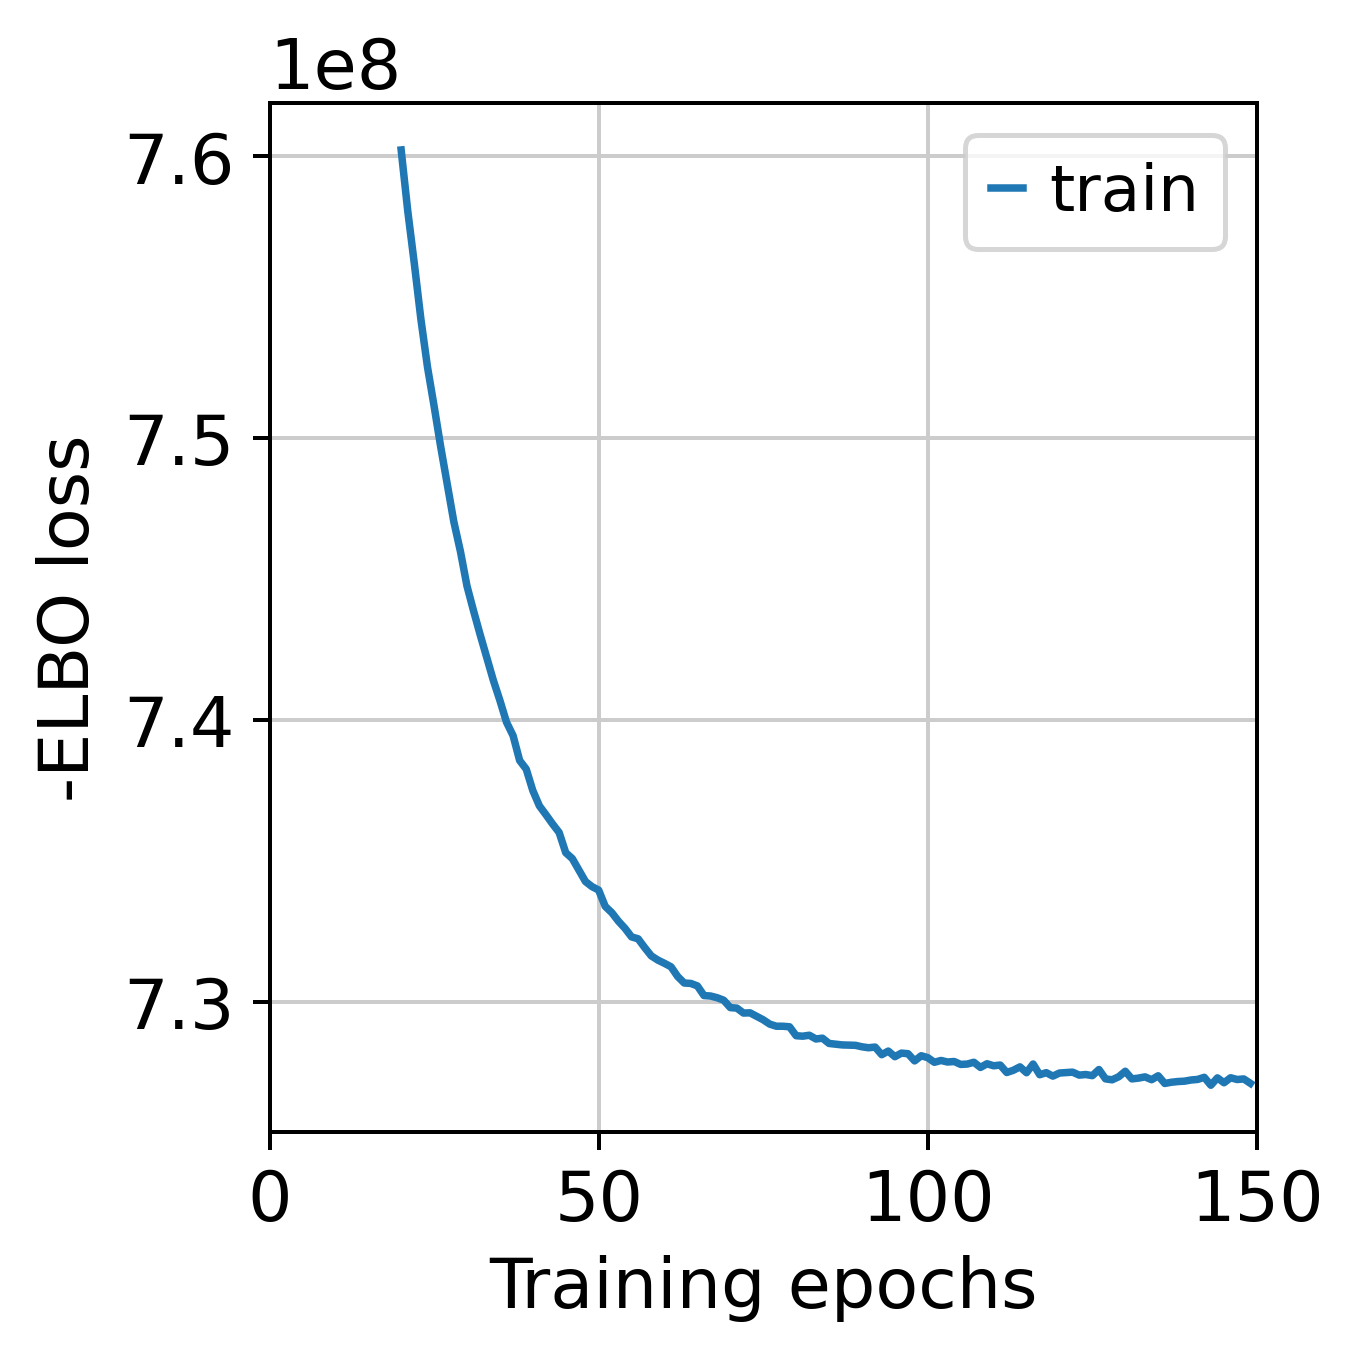

In [13]:
mod.plot_history(20)

In [14]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
)

Sampling global variables, sample: 100%|███████████████████████| 999/999 [00:14<00:00, 71.04it/s]


In [15]:
# Save model
mod.save(f"{visium_results}/reference_signatures", overwrite=True)

# Save anndata object with results
adata_file = f"{visium_results}/reference_signatures/sc.h5ad"
adata_ref.write(adata_file)
adata_file

'/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results/A1/reference_signatures/sc.h5ad'

+ Examine QC plots

In [ ]:
mod.plot_QC()

In [15]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Adult Glia,B cells,B cells AICDA LRMP,BEST4+ epithelial,Colonocyte
gene_ids,,,,,
A1BG,0.064287,0.026724,0.039433,0.000233,0.000353
A1CF,0.003266,0.000155,0.003519,0.343774,0.213597
A2M,0.164393,0.000896,0.020486,0.000564,0.000419
A4GALT,0.002785,0.006175,0.105377,0.000381,0.000112
AAAS,0.023119,0.002039,0.021123,0.024593,0.032987


## Cell2location: spatial mapping

### Slide A1 (adult colon)

+ Results folder

In [5]:
visium_results = '/../../../gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results/A1'

+ Visium data

In [6]:
visium_a1 = sc.read_h5ad('/../../../gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/slides_anndata_objects/A1_raw.h5ad')

+ Upload reference model

In [9]:
adata_ref = sc.read_h5ad(f"{visium_results}/reference_signatures/sc.h5ad")

mod = torch.load(f"{visium_results}/reference_signatures/model.pt")

In [10]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Adult Glia,B cells,B cells AICDA LRMP,BEST4+ epithelial,Colonocyte
gene_ids,,,,,
A1BG,0.064287,0.026724,0.039433,0.000233,0.000353
A1CF,0.003266,0.000155,0.003519,0.343774,0.213597
A2M,0.164393,0.000896,0.020486,0.000564,0.000419
A4GALT,0.002785,0.006175,0.105377,0.000381,0.000112
AAAS,0.023119,0.002039,0.021123,0.024593,0.032987


In [11]:
visium_a1.var_names_make_unique()

In [12]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(visium_a1.var_names, inf_aver.index)
visium_a1 = visium_a1[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=visium_a1, batch_key="Sample_ID")

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [14]:
# create and train the model
mod = cell2location.models.Cell2location(
    visium_a1, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample_ID',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 3464  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 9766  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample_ID'] │     A1     │          0          │
└────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float

Epoch 8000/8000: 100%|█████████████████| 8000/8000 [07:36<00:00, 17.12it/s, v_num=1, elbo_train=1.16e+7]

`Trainer.fit` stopped: `max_epochs=8000` reached.


Epoch 8000/8000: 100%|█████████████████| 8000/8000 [07:36<00:00, 17.52it/s, v_num=1, elbo_train=1.16e+7]


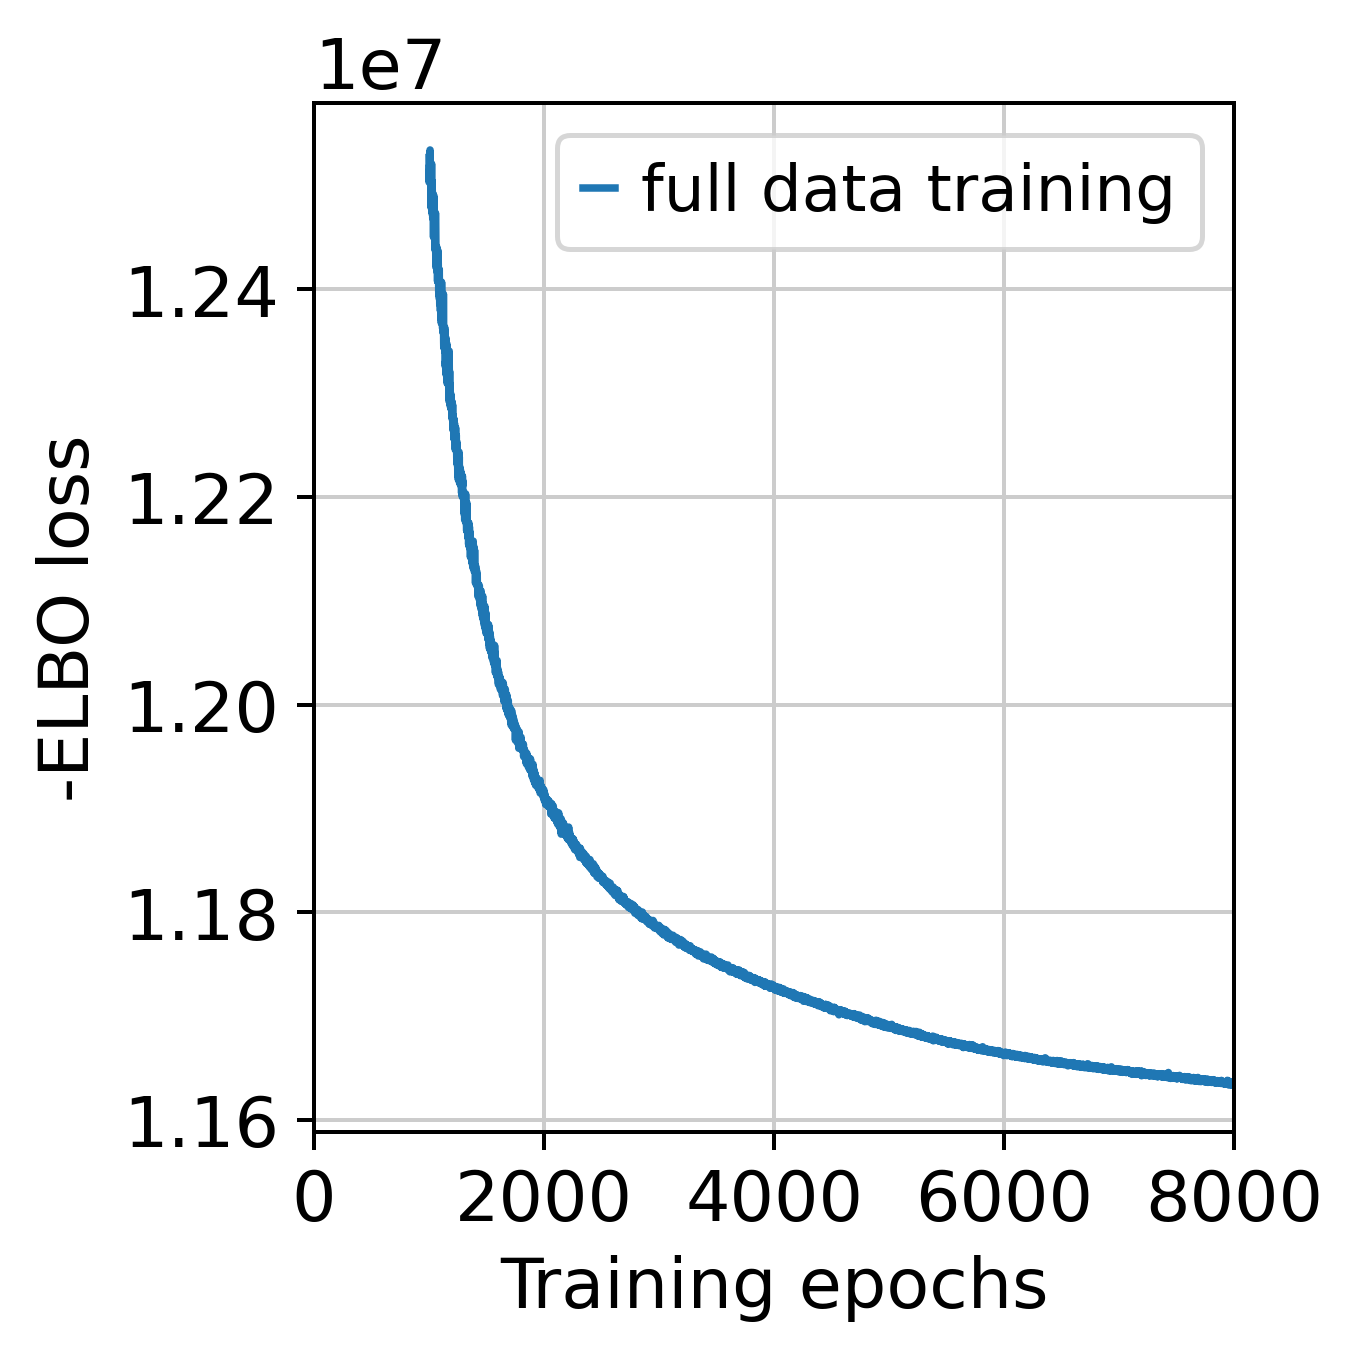

In [15]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
mod.train(max_epochs=8000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
         use_gpu = True, accelerator = "gpu", enable_progress_bar = True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

+ Exporting estimated posterior distributions of cell abundance and saving results:

In [16]:
visium_a1 = mod.export_posterior(
    visium_a1, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

Sampling global variables, sample: 100%|█████████████████████████████| 999/999 [00:09<00:00, 103.61it/s]


In [17]:
mod.save(f"{visium_results}/cell2location_map", overwrite=True)

In [18]:
adata_file = f"{visium_results}/cell2location_map/sp.h5ad"
visium_a1.write(adata_file)
adata_file

'/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results/A1/cell2location_map/sp.h5ad'

+ Assessing mapping quality

In [ ]:
mod.plot_QC()

### Visualising cell abundance in spatial coordinates

In [20]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
visium_a1.obs[visium_a1.uns['mod']['factor_names']] = visium_a1.obsm['q05_cell_abundance_w_sf']

In [21]:
visium_a1.obs['sample'] = 'tissue42'

In [24]:
visium_a1

AnnData object with n_obs × n_vars = 3464 × 9766
    obs: 'SRA_sample', 'Sample_ID', 'Sequincing_protocol', 'Library_preparation_protocol', 'Age_category', 'Age', 'Donor_ID', 'Anatomical_region', 'Sex', 'Biomaterial_description', 'barcode', 'barcode_sample_ID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_indices', '_scvi_batch', '_scvi_labels', 'Adult Glia', 'B cells', 'B cells AICDA LRMP', 'BEST4+ epithelial', 'Colonocyte', 'Cycling B cell', 'EC cells (TAC1+)', 'EECs', 'Fetal arterial EC', 'Glial cells', 'ILCs', 'IgA plasma cell', 'IgG plasma cell', 'Immune Cycling cells', 'Lymphatics', 'MAIT cell', 'Macrophages', 'Mast cells', 'Mature arterial EC', 'Mature venous EC', 'Memory B', 'Microfold cell', 'Monocytes', 'Naive B', 'Paneth cells', 'Plasma cells', 'Progenitor (NEUROG3+)', 'T cells OGT', 'T reticular', 'TA', 'Tregs', 'Tuft cells', 'arterial capillary', 'cycling EC', 'gdT', 'venous capillary', 'Myofi

In [ ]:
# select one slide
from cell2location.utils import select_slide
slide = select_slide(visium_a1, 'tissue42', batch_key='sample')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['Adult Glia', 'Stem cells', 'Paneth cells', 'TA',
                         'Colonocyte', 'Monocytes', 'Macrophages', 'Fibroblasts', 
                         'Myofibroblasts','Pericytes', 'CD4 T', 'CD8 T', 'B cells'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

In [ ]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['Stem cells', 'Paneth cells', 'TA', 'Monocytes', 'Macrophages', 'Fibroblasts']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(visium_a1, 'tissue42', batch_key='sample')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )

### Downstream analysis

+ Identifying discrete cell types by Leiden clustering

In [27]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(visium_a1, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(visium_a1, resolution=1.1)

# add region as categorical variable
visium_a1.obs["region_cluster"] = visium_a1.obs["leiden"].astype("category")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [28]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(visium_a1, min_dist = 0.3, spread = 1)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


In [ ]:
# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(visium_a1, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(visium_a1, color=['Sample_ID'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

In [ ]:
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(visium_a1, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5)

+ Identifying cellular compartments / tissue zones using matrix factorisation (NMF)

In [ ]:
from cell2location import run_colocation
res_dict, visium_a1 = run_colocation(
    visium_a1,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(5, 30), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'Sample_ID', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{visium_results}/CoLocatedComb/'}
)

In [ ]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings()

+ Estimate cell-type specific expression of every gene in the spatial data (needed for NCEM)

In [33]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

In [34]:
# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    visium_a1.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{visium_results}/cell2location_map/sp.h5ad"
visium_a1.write(adata_file)
adata_file

'/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results/A1/cell2location_map/sp.h5ad'

In [35]:
visium_a1

AnnData object with n_obs × n_vars = 3464 × 9766
    obs: 'SRA_sample', 'Sample_ID', 'Sequincing_protocol', 'Library_preparation_protocol', 'Age_category', 'Age', 'Donor_ID', 'Anatomical_region', 'Sex', 'Biomaterial_description', 'barcode', 'barcode_sample_ID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_indices', '_scvi_batch', '_scvi_labels', 'Adult Glia', 'B cells', 'B cells AICDA LRMP', 'BEST4+ epithelial', 'Colonocyte', 'Cycling B cell', 'EC cells (TAC1+)', 'EECs', 'Fetal arterial EC', 'Glial cells', 'ILCs', 'IgA plasma cell', 'IgG plasma cell', 'Immune Cycling cells', 'Lymphatics', 'MAIT cell', 'Macrophages', 'Mast cells', 'Mature arterial EC', 'Mature venous EC', 'Memory B', 'Microfold cell', 'Monocytes', 'Naive B', 'Paneth cells', 'Plasma cells', 'Progenitor (NEUROG3+)', 'T cells OGT', 'T reticular', 'TA', 'Tregs', 'Tuft cells', 'arterial capillary', 'cycling EC', 'gdT', 'venous capillary', 'Myofi

In [36]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np


def plot_genes_per_cell_type(slide, genes, ctypes):
    n_genes = len(genes)
    n_ctypes = len(ctypes)
    fig, axs = plt.subplots(
        nrows=n_genes, ncols=n_ctypes + 1, figsize=(4.5 * (n_ctypes + 1) + 2, 5 * n_genes + 1), squeeze=False
    )
    # axs = axs.reshape((n_genes, n_ctypes+1))

    # plots of every gene
    for j in range(n_genes):
        # limit color scale at 99.2% quantile of gene expression (computed across cell types)
        quantile_across_ct = np.array(
            [
                np.quantile(slide.layers[n][:, slide.var.index == genes[j]].toarray(), 0.992)
                for n in slide.uns["mod"]["factor_names"]
            ]
        )
        quantile_across_ct = np.partition(quantile_across_ct.flatten(), -2)[-2]
        sc.pl.spatial(
            slide,
            cmap="magma",
            color=genes[j],
            # layer=ctypes[i],
            gene_symbols="gene_id",
            ncols=4,
            size=1.3,
            img_key="hires",
            # limit color scale at 99.2% quantile of gene expression
            vmin=0,
            vmax="p99.2",
            ax=axs[j, 0],
            show=False,
        )

        # plots of every cell type
        for i in range(n_ctypes):
            sc.pl.spatial(
                slide,
                cmap="magma",
                color=genes[j],
                layer=ctypes[i],
                gene_symbols="gene_id",
                ncols=4,
                size=1.3,
                img_key="hires",
                # limit color scale at 99.2% quantile of gene expression
                vmin=0,
                vmax=quantile_across_ct,
                ax=axs[j, i + 1],
                show=False,
            )
            axs[j, i + 1].set_title(f"{genes[j]} {ctypes[i]}")

    return fig, axs

In [ ]:
# list cell types and genes for plotting
ctypes = ['Paneth cells', 'TA', 'Stem cells']
genes = ['LGR5', 'OLFM4', 'ASCL2', 'RGMB', 'MKI67', 'UBE2C', 'TOP2A', 'SMOC2', 'DEFA5', 'DEFA6', 'REG3A']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(visium_a1, 'tissue42', batch_key='sample')

    plot_genes_per_cell_type(slide, genes, ctypes);

### Working with the posterior distribution and computing arbitrary quantiles

In [38]:
# Get posterior distribution samples for specific variables
samples_w_sf = mod.sample_posterior(num_samples=1000, use_gpu=True, return_samples=True,
                                    batch_size=2020,
                                    return_sites=['w_sf', 'm_g', 'u_sf_mRNA_factors'])
# samples_w_sf['posterior_samples'] contains 1000 samples as arrays with dim=(num_samples, ...)
samples_w_sf['posterior_samples']['w_sf'].shape

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|█████████████████████████████| 999/999 [00:07<00:00, 129.03it/s]


(1000, 3464, 48)

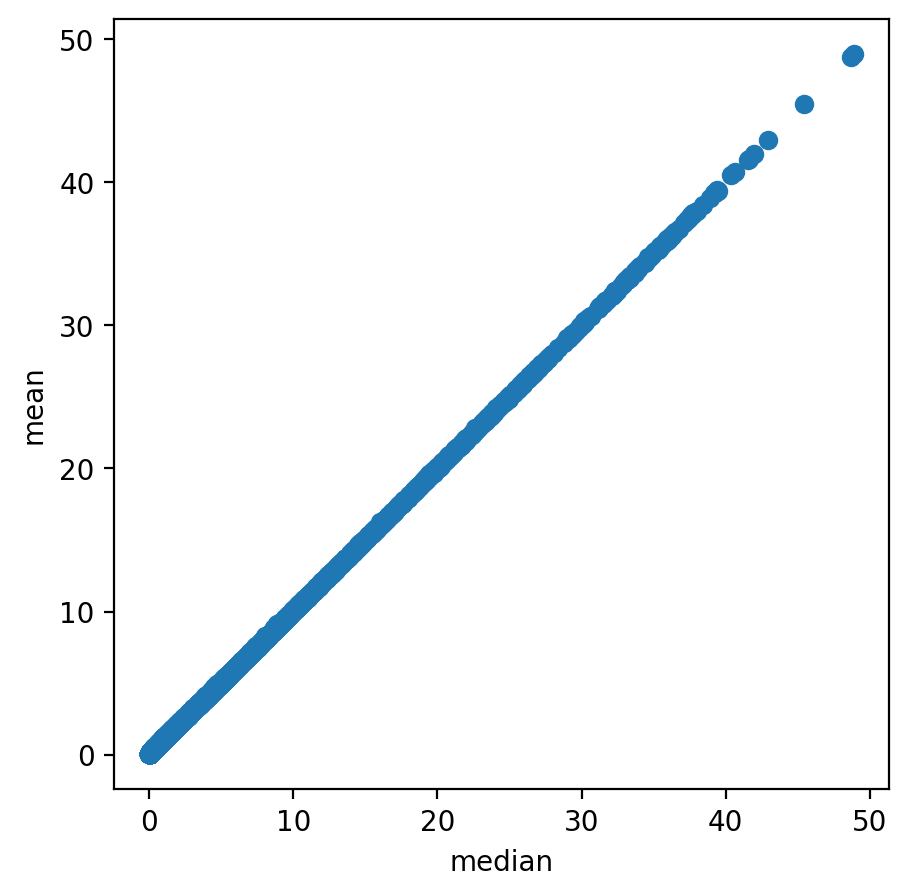

In [39]:
# Compute any quantile of the posterior distribution
medians = mod.posterior_quantile(q=0.5, batch_size=mod.adata.n_obs, use_gpu=True)

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    plt.scatter(medians['w_sf'].flatten(), mod.samples['post_sample_means']['w_sf'].flatten());
    plt.xlabel('median');
    plt.ylabel('mean');

### Slide A2 (adult colon)

+ Upload trained model

In [41]:
adata_ref = sc.read_h5ad(f"{visium_results}/reference_signatures/sc.h5ad")

mod = torch.load(f"{visium_results}/reference_signatures/model.pt")

+ Define new results folder and new anndata object

In [42]:
visium_results = '/../../../gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results/A2'

In [43]:
visium_a2 = sc.read_h5ad('/../../../gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/slides_anndata_objects/A2_raw.h5ad')

In [44]:
visium_a2.var_names_make_unique()

In [45]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(visium_a2.var_names, inf_aver.index)
visium_a2 = visium_a2[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=visium_a2, batch_key="Sample_ID")

In [46]:
# create and train the model
mod = cell2location.models.Cell2location(
    visium_a2, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample_ID',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 2810  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 9766  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample_ID'] │     A2     │          0          │
└────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:281: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 8000/8000: 100%|█████████████████| 8000/8000 [07:22<00:00, 17.00it/s, v_num=1, elbo_train=1.37e+7]

`Trainer.fit` stopped: `max_epochs=8000` reached.


Epoch 8000/8000: 100%|█████████████████| 8000/8000 [07:22<00:00, 18.08it/s, v_num=1, elbo_train=1.37e+7]


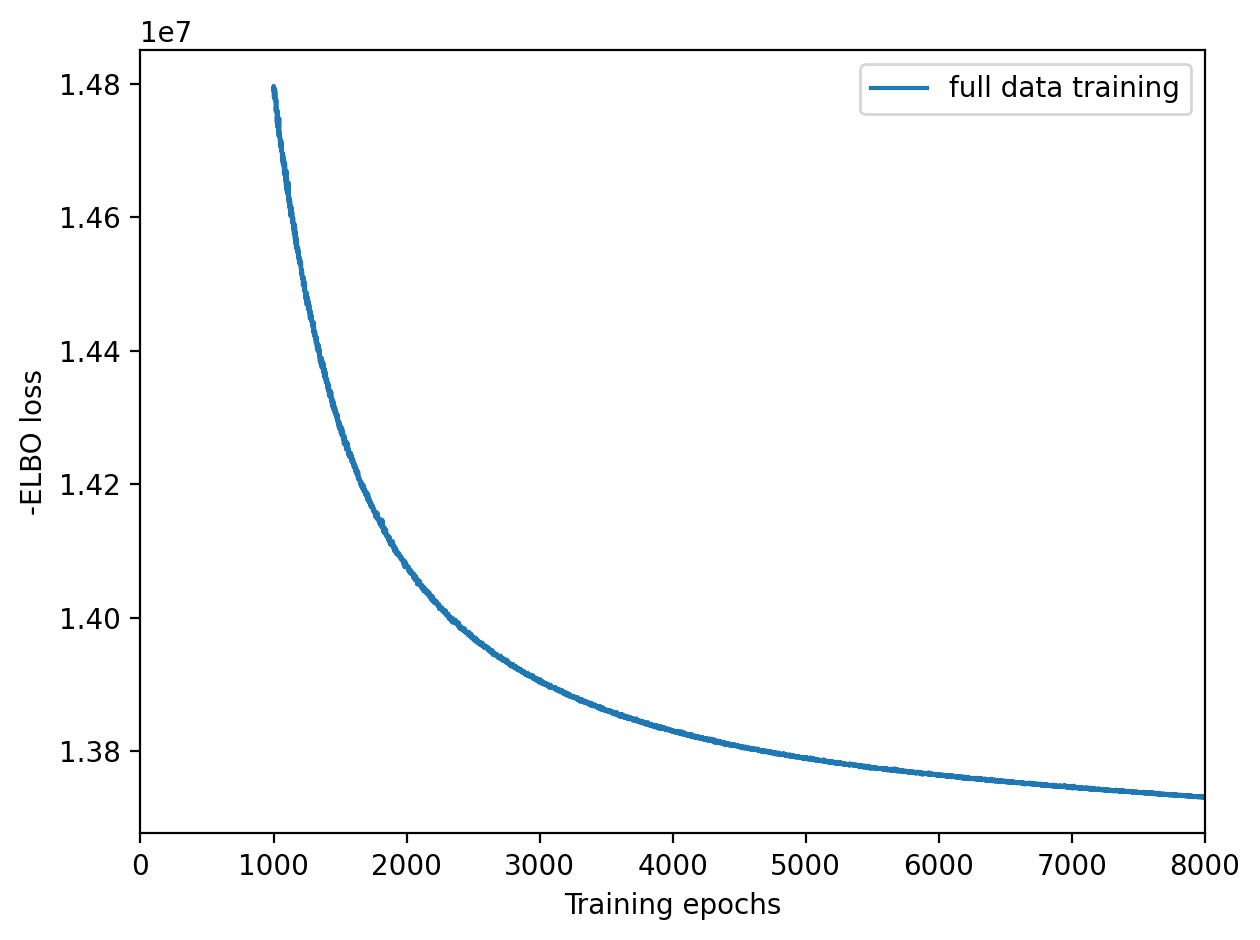

In [47]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
mod.train(max_epochs=8000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
         use_gpu = True, accelerator = "gpu", enable_progress_bar = True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

+ Exporting estimated posterior distributions of cell abundance and saving results:

In [48]:
visium_a2 = mod.export_posterior(
    visium_a2, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

Sampling global variables, sample: 100%|█████████████████████████████| 999/999 [00:08<00:00, 111.31it/s]


In [49]:
mod.save(f"{visium_results}/cell2location_map", overwrite=True)

In [50]:
adata_file = f"{visium_results}/cell2location_map/sp.h5ad"
visium_a2.write(adata_file)
adata_file

'/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results/A2/cell2location_map/sp.h5ad'

+ Assessing mapping quality

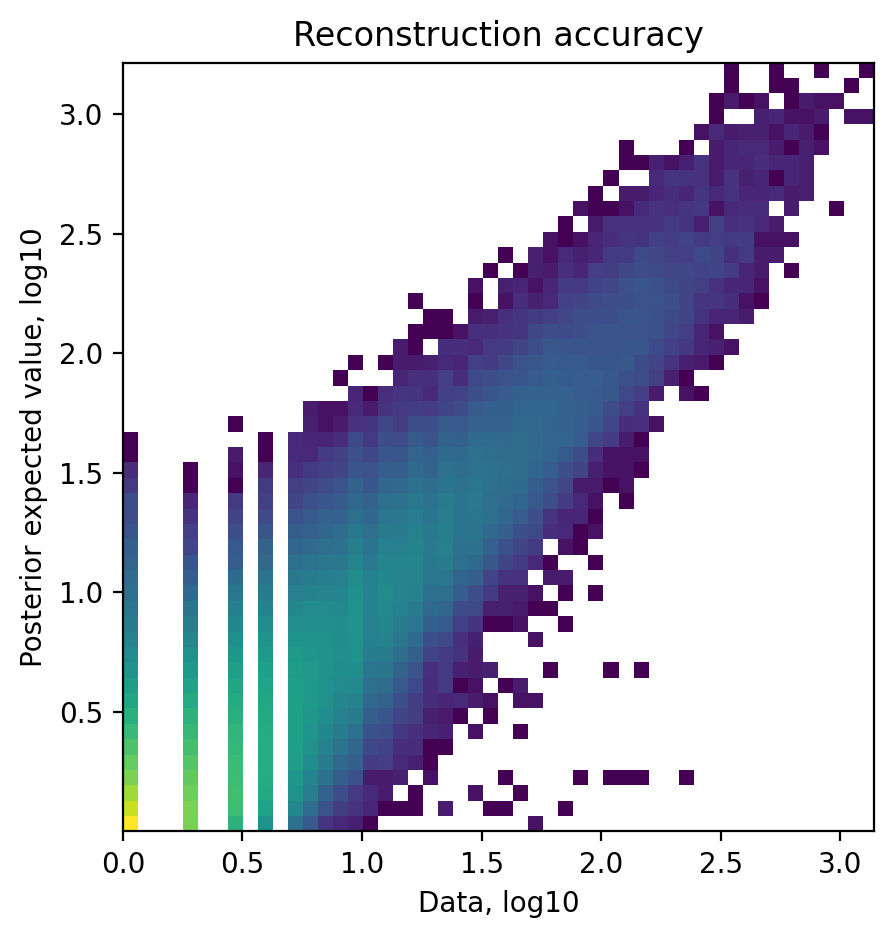

In [51]:
mod.plot_QC()

### Visualising cell abundance in spatial coordinates

In [52]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
visium_a2.obs[visium_a2.uns['mod']['factor_names']] = visium_a2.obsm['q05_cell_abundance_w_sf']

In [53]:
visium_a2.obs['sample'] = 'tissue42'

In [ ]:
# select one slide
from cell2location.utils import select_slide
slide = select_slide(visium_a2, 'tissue42', batch_key='sample')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['Adult Glia', 'Stem cells', 'Paneth cells', 'TA',
                         'Colonocyte', 'Monocytes', 'Macrophages', 'Fibroblasts', 
                         'Myofibroblasts','Pericytes', 'CD4 T', 'CD8 T', 'B cells'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

In [ ]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['Stem cells', 'Paneth cells', 'TA', 'Monocytes', 'Macrophages', 'Fibroblasts']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(visium_a2, 'tissue42', batch_key='sample')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )

### Downstream analysis

+ Identifying discrete cell types by Leiden clustering

In [56]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(visium_a2, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(visium_a2, resolution=1.1)

# add region as categorical variable
visium_a2.obs["region_cluster"] = visium_a2.obs["leiden"].astype("category")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [57]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(visium_a2, min_dist = 0.3, spread = 1)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


In [ ]:
# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(visium_a2, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(visium_a2, color=['Sample_ID'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

In [ ]:
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(visium_a2, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5)

+ Identifying cellular compartments / tissue zones using matrix factorisation (NMF)

In [60]:
from cell2location import run_colocation
res_dict, visium_a2 = run_colocation(
    visium_a2,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(5, 30), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'Sample_ID', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{visium_results}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_5combinations_2810locations_48factors
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_6combinations_2810locations_48factors
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_7combinations_2810locations_48factors
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_8combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_9combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_10combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_13combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_14combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_15combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_16combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_17combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_18combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_19combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_20combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_21combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_22combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_23combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_24combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_25combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_26combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_27combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_28combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0
### Analysis name: CoLocatedGroupsSklearnNMF_29combinations_2810locations_48factors


/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0


In [ ]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings()

+ Estimate cell-type specific expression of every gene in the spatial data (needed for NCEM)

In [62]:
mod.samples

{'post_sample_means': {'n_s_cells_per_location': array([[38.929386],
         [31.95011 ],
         [32.97188 ],
         ...,
         [31.690754],
         [30.334227],
         [32.15873 ]], dtype=float32),
  'b_s_groups_per_location': array([[21.130232],
         [22.192968],
         [21.977701],
         ...,
         [22.191057],
         [22.979822],
         [21.555822]], dtype=float32),
  'z_sr_groups_factors': array([[0.6573153 , 1.3863946 , 0.03495586, ..., 1.4141839 , 0.96508   ,
          1.1990035 ],
         [0.9442978 , 0.72284025, 1.1204171 , ..., 0.34912157, 0.6884359 ,
          0.78585714],
         [0.5758656 , 0.93427193, 0.03324359, ..., 0.23826909, 0.71766126,
          0.77867025],
         ...,
         [0.9985611 , 0.77369004, 0.7437433 , ..., 0.15301986, 0.618655  ,
          0.68943095],
         [0.826911  , 0.6645517 , 1.2284325 , ..., 0.28083137, 0.663402  ,
          0.63137263],
         [0.42296535, 0.7734299 , 0.02249171, ..., 0.23230645, 0.7274688 

In [63]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

In [64]:
# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    visium_a2.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{visium_results}/cell2location_map/sp.h5ad"
visium_a2.write(adata_file)
adata_file

'/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Visium_fawkner_corbett/cell2location_results/A2/cell2location_map/sp.h5ad'

In [ ]:
# list cell types and genes for plotting
ctypes = ['Paneth cells', 'TA', 'Stem cells']
genes = ['LGR5', 'OLFM4', 'ASCL2', 'RGMB', 'MKI67', 'UBE2C', 'TOP2A', 'SMOC2', 'DEFA5', 'DEFA6', 'REG3A']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(visium_a2, 'tissue42', batch_key='sample')

    plot_genes_per_cell_type(slide, genes, ctypes);

### Working with the posterior distribution and computing arbitrary quantiles

In [66]:
# Get posterior distribution samples for specific variables
samples_w_sf = mod.sample_posterior(num_samples=1000, use_gpu=True, return_samples=True,
                                    batch_size=2020,
                                    return_sites=['w_sf', 'm_g', 'u_sf_mRNA_factors'])
# samples_w_sf['posterior_samples'] contains 1000 samples as arrays with dim=(num_samples, ...)
samples_w_sf['posterior_samples']['w_sf'].shape

/home/amaguza/miniforge3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|█████████████████████████████| 999/999 [00:07<00:00, 136.56it/s]


(1000, 2810, 48)

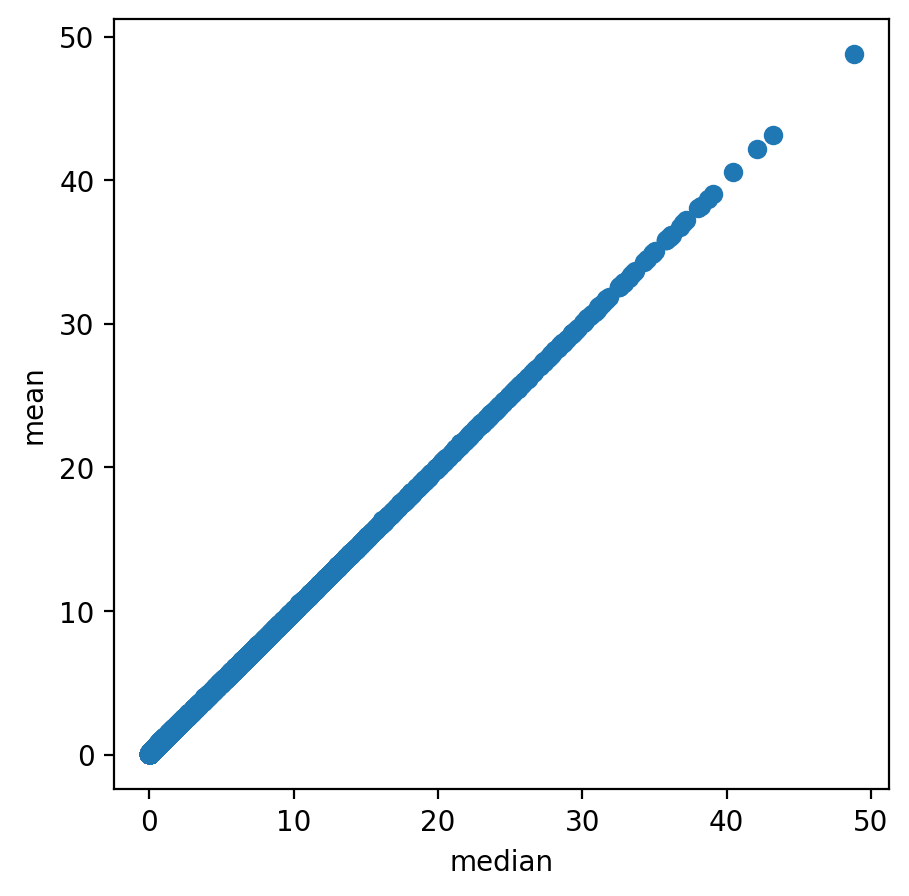

In [67]:
# Compute any quantile of the posterior distribution
medians = mod.posterior_quantile(q=0.5, batch_size=mod.adata.n_obs, use_gpu=True)

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    plt.scatter(medians['w_sf'].flatten(), mod.samples['post_sample_means']['w_sf'].flatten());
    plt.xlabel('median');
    plt.ylabel('mean');